In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import dataset as dd # custom dataset class
import unet
from unet import UNet, shortcuts

# so that when you change an imported file, it changes in the notebook
%load_ext autoreload 
%autoreload 2
%matplotlib notebook

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

im_ref, im_us = dd.get_dataset(1)
X_train, y_train = (im_us,  im_ref)

im_ref_test, im_us_test = dd.get_dataset(3)
X_test, y_test = (im_us_test, im_ref_test)



In [2]:
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

('Training data shape: ', (320, 320, 256, 8))
('Training labels shape: ', (320, 320, 256, 1))
('Test data shape: ', (320, 320, 256, 8))
('Test labels shape: ', (320, 320, 256, 1))


In [3]:
# Define layers
C1 = shortcuts.conv(filters=16, kernel_size=(3, 3), padding='same', strides=(1,1), activation='relu')
M1 = shortcuts.maxpool(pool_size=(2, 2), strides=(2, 2), padding='same')
C2 = shortcuts.conv(filters=32, kernel_size=(3, 3), padding='same', strides=(1,1), activation='relu')

# "un" versions are my name for the upsampling path
# "unconv" automatically concatenates the output from the corresponding
# layer in the contracting network
C3 = shortcuts.unconv(filters=32, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu')
U1 = shortcuts.unmaxpool(size=(2, 2))
C4 = shortcuts.unconv(filters=16, kernel_size=(3, 3), padding='same', strides=(1,1), activation='relu')
D1 = shortcuts.fc(1)

input_shape = X_train.shape[1:]
U = UNet(input_shape, C1, M1, C2, C3, U1, C4, D1)

In [4]:
U.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 256, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 320, 256, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 160, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 160, 128, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 160, 128, 32)      9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 320, 256, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 320, 256, 16)      4624      
__________

In [5]:
history = U.train(X_train, y_train, epochs=20)

Epoch 1/20
320/320 [==============================] - 14s 44ms/step - loss: 7.4988e-04 - mean_squared_error: 7.4988e-04
Epoch 2/20
320/320 [==============================] - 8s 25ms/step - loss: 2.6800e-04 - mean_squared_error: 2.6800e-04
Epoch 3/20
320/320 [==============================] - 7s 21ms/step - loss: 2.2241e-04 - mean_squared_error: 2.2241e-04
Epoch 4/20
320/320 [==============================] - 7s 22ms/step - loss: 2.0065e-04 - mean_squared_error: 2.0065e-04
Epoch 5/20
320/320 [==============================] - 8s 24ms/step - loss: 1.8910e-04 - mean_squared_error: 1.8910e-04
Epoch 6/20
320/320 [==============================] - 8s 24ms/step - loss: 1.7981e-04 - mean_squared_error: 1.7981e-04
Epoch 7/20
320/320 [==============================] - 8s 25ms/step - loss: 1.7184e-04 - mean_squared_error: 1.7184e-04
Epoch 8/20
320/320 [==============================] - 8s 24ms/step - loss: 1.6342e-04 - mean_squared_error: 1.6342e-04
Epoch 9/20
320/320 [===========================

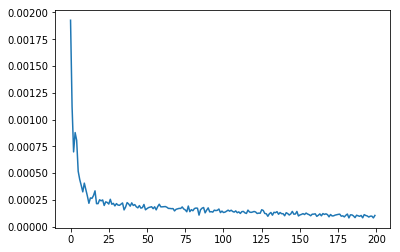

In [6]:
plt.plot(history.losses)
plt.show()

In [17]:
pred = U.predict(X_test)

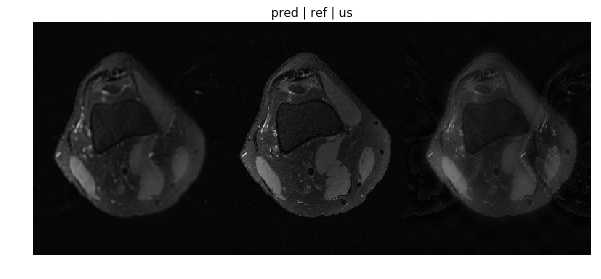

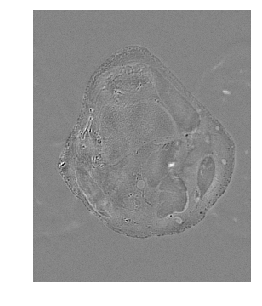

In [19]:
slice_to_show = 100

def sos(im, axis):
    return np.sqrt(np.sum(np.power(im, 2), axis=axis))

im1 = im_ref_test[slice_to_show, :, :, 0]
im2 = sos(im_us_test[slice_to_show, :, :, :], axis=2)
im3 = pred[slice_to_show, :, :, 0]


fig = plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((im3, im1, im2)), cmap='gray')
plt.title('pred | ref | us')
plt.axis('off')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.imshow(im3 - im1, cmap='gray')
plt.axis('off')
plt.show()